<a href="https://colab.research.google.com/github/mithun-martin/SEIZURE_PREDICTION_RANDOM_FOREST/blob/main/EEG_RANDOM_FOREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# #LOGIC
# 1)install all libraries
# 2)setup the training datas downloading them and defining seizure times
# 3)Visualizing one patients dta before and after adding filter
# 4)defining function for feature extraction by calculating mean varinces and kurtosis from an input signal and its freq
# 5)looping through the training files and chopping into 4sec windows and applying step 4 func to conv them to  nos
# 6)Training the model
# 7)Testing

In [ ]:
#BLOCK 1 INSTALLING ALL LIBRARIES


!pip install mne
#pyedflib & mne: These are the names of the packages we want to download. mne is the industry standard for EEG analysis.

!pip install git+https://github.com/forrestbao/pyeeg.git

# #1. What is PyEEG?
# PyEEG is a small, specialized library written by a researcher named Forrest Bao in 2011.
# It is not a general-purpose tool. It is a specific collection of advanced mathematical formulas used to measure "Chaos" and "Complexity" in time-series data (like brain waves).
# What is inside it? It contains the hard-to-code formulas that standard libraries (like scipy or numpy) forgot to include:
# Fractal Dimensions: Measures how "rough" or "jagged" a line is (Petrosian and Higuchi Fractal Dimension).
# Entropy: Measures how "surprising" or "random" the data is (Approximate Entropy, Sample Entropy, Spectral Entropy)
# Hurst Exponent: Measures the long-term memory of a signal.
# PyEEG is "Academic Code." It was written by a scientist to support a research paper. Once the paper was published, the "product" was finished. It doesn't have a marketing team or a maintenance team updating it every month. It is a "niche" tool for a tiny group of scientists.
# 3. Why is it "unavailable" anywhere else?
# Usually, you download libraries from PyPI (The Python Package Index) using pip install name.
# However, because pyeeg is an older academic project, the version on the "App Store" (PyPI) is often broken, outdated, or simply missing.
# If you type pip install pyeeg: It might try to download a version from 2012 that crashes on modern Python.
# Why we use git+https://...: This commands the computer to skip the "App Store" and go straight to the author's Source Code on GitHub. It downloads the raw files directly from the shelf where the scientist left them.


import mne
import pyeeg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import os


print("✅ Professional modules and PyEEG loaded successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 52.7 MB/s eta 0:00:00
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-so1pkd2z
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-so1pkd2z
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28114 sha256=fcb182f475367e29cb2801bff9227a3aaca8bac88ba7e55ef2a98aeeed761360
  Stored in directory: /tmp/pip-ephem-wheel-cache-4doivswj/wheels/a8/82/7e/6b841dd4f72f1cb68f0d55333fbdf4d248e62bdbae17be9a1b
Successfully built pyeeg
✅ Professional modules and PyEEG loaded successfully!


In [ ]:
# #BLOCK 2  setup the training datas downloading them and defining seizure times
# import os

# #defining training files names and also sezure times labbeles
# train_files =["chb01_03.edf", "chb05_13.edf", "chb08_11.edf"]

# seizure_times = {
#     "chb01_03.edf": (2996, 3036),
#     "chb05_13.edf": (3462, 3476),
#     "chb08_11.edf": (2677, 2682)
# }



# if not os.path.exists("chb01_03.edf"):
#   os.system("wget -q https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf")
#   print("⬇️ Downloaded Patient 01")
# #"Check my folder. If the file 'chb01_03.edf' is NOT there, then do the next step (download it). If it IS there, skip the download."

# if not os.path.exists("chb05_13.edf"):
#     os.system("wget -q https://physionet.org/files/chbmit/1.0.0/chb05/chb05_13.edf")
#     print("⬇️ Downloaded Patient 05")

# if not os.path.exists("chb08_11.edf"):
#     os.system("wget -q https://physionet.org/files/chbmit/1.0.0/chb08/chb08_11.edf")
#     print("⬇️ Downloaded Patient 08")

# print("✅ Training data is ready!")





In [ ]:
# ==========================================
# BLOCK 2: SETUP TRAINING DATA (12 FILES)
# ==========================================
import os

print("⬇️ STARTING BULK DOWNLOAD (12 Files)... This may take ~3 mins.")

# 1. THE GOLDEN DICTIONARY
# Format: "Filename": [(Start1, End1), (Start2, End2), ...]
seizure_times = {
    # Patient 01 (The main training set)
    "chb01_03.edf": [(2996, 3036)],
    "chb01_04.edf": [(1467, 1494)],
    "chb01_15.edf": [(1732, 1772)],
    "chb01_16.edf": [(1015, 1066)],
    "chb01_18.edf": [(1720, 1810)],
    "chb01_26.edf": [(1862, 1963)],

    # Patient 02 (Has MULTIPLE seizures in one file!)
    "chb02_16.edf": [(130, 212), (2972, 3053)],  # <--- DOUBLE SEIZURE FILE
    "chb02_19.edf": [(3369, 3378)],

    # Patient 03 (Different brain patterns)
    "chb03_01.edf": [(362, 414)],
    "chb03_02.edf": [(731, 796)],

    # Patient 05 & 08 (Short seizures)
    "chb05_13.edf": [(3462, 3476)],
    "chb08_11.edf": [(2677, 2682)]
}

# 2. SMART AUTOMATIC DOWNLOADER
# We don't write 12 "if" statements. We loop.
train_files = list(seizure_times.keys())  #we get the list of the left side of colonin dict that is in short the name sof the files we fetced for training
#['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf'] etc

for file in train_files:
    if not os.path.exists(file):
        # Logic: "chb01_03.edf" -> Patient ID is "chb01"
        patient_id = file.split('_')[0]
        url = f"https://physionet.org/files/chbmit/1.0.0/{patient_id}/{file}"

        print(f"  -> Downloading {file} from {patient_id}...")
        os.system(f"wget -q {url}")
    else:
        print(f"  -> Found {file}, skipping.")

print("✅ ALL 12 FILES READY. DATASET IS ROBUST.")

⬇️ STARTING BULK DOWNLOAD (12 Files)... This may take ~3 mins.
  -> Downloading chb01_03.edf from chb01...
  -> Downloading chb01_04.edf from chb01...
  -> Downloading chb01_15.edf from chb01...
  -> Downloading chb01_16.edf from chb01...
  -> Downloading chb01_18.edf from chb01...
  -> Downloading chb01_26.edf from chb01...
  -> Downloading chb02_16.edf from chb02...
  -> Downloading chb02_19.edf from chb02...
  -> Downloading chb03_01.edf from chb03...
  -> Downloading chb03_02.edf from chb03...
  -> Downloading chb05_13.edf from chb05...
  -> Downloading chb08_11.edf from chb08...
✅ ALL 12 FILES READY. DATASET IS ROBUST.


📊 Visualizing Data Cleaning (One Channel)...


/tmp/ipython-input-1605978749.py:16: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_name, preload=True, verbose=False)


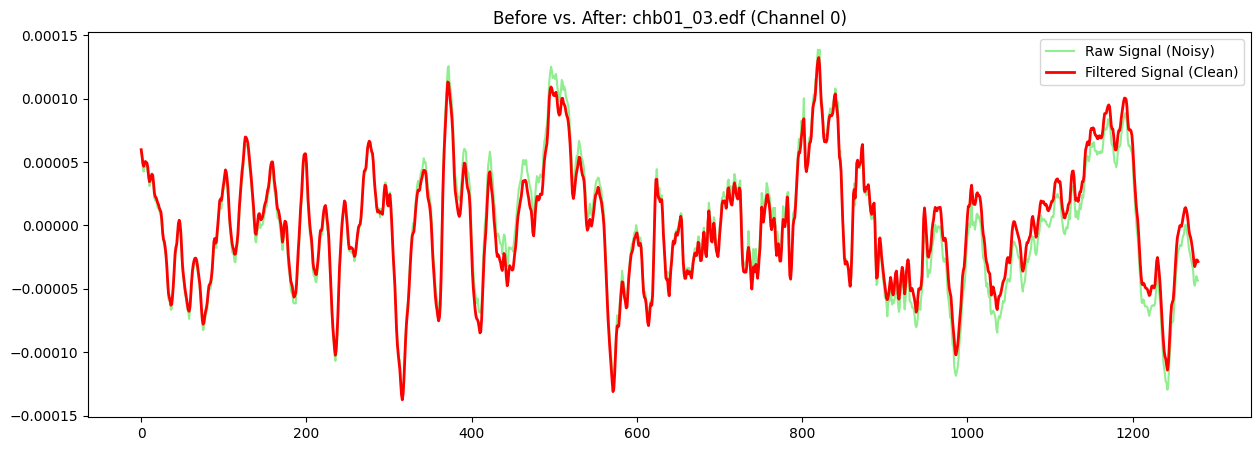

In [ ]:
# ==========================================
# BLOCK 3: VISUALIZING THE "CAR WASH" (Simple)
# ==========================================
import matplotlib.pyplot as plt
import mne

print("📊 Visualizing Data Cleaning (One Channel)...")

# 1. SETUP: Pick the first file and its first seizure time
file_name = train_files[0]                      # Grab the first file (chb01_03.edf)
#now seizure_times[file_name][0] = The Value inside the dictionary of grabbed first file [(2996, 3036)] which refres to hwole list of siezure in this  file
seizure_start = seizure_times[file_name][0][0]  # Grab the start time (2996s)

# 2. LOAD & CLEAN
# Load the Dirty version
raw = mne.io.read_raw_edf(file_name, preload=True, verbose=False)

# Create the Clean version (Filter 1-70Hz + Remove 60Hz hum)
clean = raw.copy().filter(1, 70, verbose=False).notch_filter(60, verbose=False)

# 3. GRAB 5 SECONDS OF DATA
# We focus on just ONE channel (Channel 0) to make it easy to see
# tmin = start of seizure, tmax = 5 seconds later
data_raw = raw.get_data(picks=0, tmin=seizure_start, tmax=seizure_start+5)[0]
data_clean = clean.get_data(picks=0, tmin=seizure_start, tmax=seizure_start+5)[0]

# 4. PLOT THE RESULT
plt.figure(figsize=(15, 5))
plt.plot(data_raw, color='lightgreen', label='Raw Signal (Noisy)')
plt.plot(data_clean, color='red', linewidth=2, label='Filtered Signal (Clean)')

plt.title(f"Before vs. After: {file_name} (Channel 0)")
plt.legend()
plt.show()
#y axis voltage and x axis = sample data points
#5 sec windo we showing...so 5 into 256 almost equals just over 1200 thats the samle datapoitnts on x axis

In [ ]:
def extract_advanced_features(signal, sfreq):
    # 1. Basic Statistics (Time Domain)
    mean = np.mean(signal)
    var = np.var(signal)
    kurt = kurtosis(signal)

    # 2. Nonlinear Complexity (Fractal Geometry)
    pfd = pyeeg.pfd(signal)
    hfd = pyeeg.hfd(signal, 6)

    # 3. Spectral Entropy (Frequency Domain)
    bands = [0.5, 4, 8, 12, 30, 70]
    # This line defines the boundaries of the "buckets" we want to sort the energy into., 0.5 to 4: Everything between these numbers is Delta (Deep Sleep)., 4 to 8: Everything here is Theta (Drowsy).
    # 8 to 12: Everything here is Alpha (Relaxed).,..12 to 30: Everything here is Beta (Thinking)....,30 to 70: Everything here is Gamma (Excited/Seizure).
    # We need this list so the next function knows exactly where to slice the signal.

    # Calculate Power & Entropy directly
    power_dist, _ = pyeeg.bin_power(signal, bands, sfreq)
    entropy = pyeeg.spectral_entropy(signal, bands, sfreq, power_dist)

    return [mean, var, kurt, pfd, hfd, entropy]

In [ ]:
# --- PART 2: THE MAIN LOOP ---
train_features = [] #Will hold the Math (Mean, Variance, etc.).


train_labels = [] #Will hold the Answers (0 for Healthy, 1 for Seizure).

print("🏭 STARTING FACTORY MODE...")

for filename in train_files:
    print(f"  -> Extracting from {filename}...")

    # 1. READ & CLEAN
    try:
        raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)
    except:
        print(f"    ⚠️ Error reading {filename}, skipping.")
        continue

    raw.rename_channels(lambda x: x.strip('.'))
    raw.filter(1.0, 70.0, verbose=False)

    # 2. PREPARE SCISSORS
    data = raw.get_data()  #raw as a locked suitcase. It contains the data, but it also contains "metadata" (the date, the patient's name, the hospital name, the camera speed).
    #data = raw.get_data() is the command to dump the contents onto the table. It throws away the patient's name and the date, and gives you pure, raw numbers.
    sfreq = raw.info['sfreq'] #What happens: It looks at the file header to see how fast the data was recorded....Usually 256.0 (Hz).
    win_len = int(4 * sfreq) # 4 seconds = 1024 data points
    n_wins = data.shape[1] // win_len  #Axis 0 (Height): This is your list of Electrodes (FP1, F7, T7...).
    #data.shape[0] = 23 (You have 23 channels). Axis 1 (Width): This is your Timeline (Tick, tick, tick...).
    #data.shape[1] = 921,600 (You have nearly a million time points).

    # 3. GET SEIZURE LIST (Safe for multiple seizures)
    seizure_list = seizure_times.get(filename, [])
    #for each training file get a list of the sezure times of it (of the given filename) eg (e.g., [(100, 120)]),.. if not exist hen return empty list []

    # now a loop for each individual window inside a particular file

    #4. PROCESS WINDOWS
    for i in range(n_wins):
        clip = data[:, i*win_len : (i+1)*win_len]
        #i = for each winow inisde file i = 0,1,2..
        # The Syntax [:, start:end],....The first : means "Take ALL rows" (we want all 23 channels)
        #The second part determines the columns (time).
        # Loop 0: 0 to 1024 (First 4 seconds)...WIN LEN USUALLY 256
        # Loop 1: 1024 to 2048 (Next 4 seconds).


        # Calculate Math Features for every channel
        row = []
        for ch in range(clip.shape[0]): #Loop through every electrode (Channel 0 to Channel 22).We need to calculate math features for every single channel separately.
            row.extend(extract_advanced_features(clip[ch], sfreq)) #Do the math and pour the results into the box
        train_features.append(row)
        #Throw the full box into the Shipping Containe

        # LABELING (0 = Healthy, 1 = Seizure)
        t = i * 4 #Translation: "What time is it?",..Converts the Window Index (i) into real-world Seconds.
        #Window 0 -> 0s. Window 1 -> 4s. Window 2 -> 8s.

        is_seizure = 0
        #Assume the patient is healthy until proven otherwise

        # Check if 't' is inside ANY seizure in the list
        for (start, end) in seizure_list: #We loop through every seizure recorded for this file
            if start <= t <= end: #Is the current time t inside the danger zone?
                is_seizure = 1
                break

        train_labels.append(is_seizure)

# --- PART 3: SAVE & VISUALIZE ---
df_final = pd.DataFrame(train_features) #Convert the list of lists into pandas dataframes
df_final['label'] = train_labels

print("\n👀 PREVIEW OF YOUR DATA (First 5 Rows):")
print(df_final.head())
#Show me the first 5 rows

counts = df_final['label'].value_counts() #It tallies up how many 0s and how many 1s are in the column.
print("\n⚖️ DATA BALANCE:")
print(f"   - Healthy Windows (0): {counts.get(0, 0)}")
print(f"   - Seizure Windows (1): {counts.get(1, 0)}")

df_final.to_csv("train_features.csv", index=False)  #Save this table to my Hard Drive as a CSV file
print(f"\n✅ SUCCESS! Saved 'train_features.csv' with {len(df_final)} samples.")

🏭 STARTING FACTORY MODE...
  -> Extracting from chb01_03.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb01_04.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb01_15.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb01_16.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb01_18.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb01_26.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb02_16.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb02_19.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb03_01.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb03_02.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb05_13.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


  -> Extracting from chb08_11.edf...


/tmp/ipython-input-2657250903.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)



👀 PREVIEW OF YOUR DATA (First 5 Rows):
              0             1         2         3         4         5  \
0  1.219813e-06  8.056177e-10 -0.059166  0.608657  0.124872  0.280445   
1 -7.069279e-07  4.990803e-10 -0.152713  0.599691  0.244301  0.225971   
2 -1.064495e-07  1.201298e-09  1.400648  0.614187  0.108413  0.316898   
3  6.131093e-07  9.187969e-10  0.830097  0.604626  0.130543  0.313743   
4  5.445468e-07  5.530167e-10  0.119833  0.602413  0.154749  0.255897   

              6             7         8         9  ...       129       130  \
0 -1.290890e-06  7.169271e-10  0.119297  0.601983  ...  0.588627  0.234476   
1 -1.727850e-06  5.655914e-10  0.395979  0.600511  ...  0.584433  0.328743   
2  4.149444e-07  1.052273e-09  0.109754  0.607434  ...  0.599489  0.208323   
3 -1.747168e-07  7.029521e-10 -0.184402  0.603065  ...  0.592239  0.235384   
4 -6.489736e-07  4.529114e-10  0.225238  0.606478  ...  0.585883  0.276337   

        131           132           133       134   

In [ ]:
#  The Columns (0, 1, 2... 137)These are the "Questions" for the exam.Column 0: Might be "Average Voltage of Channel 1
#Column 1: Might be "Variance of Channel 1".Column 134: Might be "Entropy of Channel 23".There are 137 columns because you calculated 6 math features for all 23 channels ($23 \times 6 \approx 138$).

In [ ]:
# What is SMOTE? (The "Lazy Student" Problem)
# SMOTE stands for Synthetic Minority Over-sampling TEchnique.
# The Problem: The Lazy AI Imagine you give a student a test with 100 questions.
# 99 questions are "True". 1 question is "False" (The Seizure).
# If the student is lazy, they will just write "True" for every single answer.
# Result: They get a score of 99%.
# Reality: They failed the only question that mattered (detecting the seizure).
# The Solution: SMOTE (The Cloner) SMOTE fixes this by creating Fake Seizures. It looks at your 1 seizure example and mathematically invents 98 new ones that look similar but slightly different.
# Before SMOTE: 99 Normal vs. 1 Seizure. (AI ignores the seizure).
#After SMOTE: 99 Normal vs. 99 Seizures. (AI must learn the difference to pass).

🧠 Training with SMOTE (Random Forest Only)...
   -> Original Samples: 9820
   -> After SMOTE:      19344 (Balanced!)

📊 --- MODEL PERFORMANCE REPORT (TRAINING DATA) ---
✅ Accuracy: 100.00%

📝 Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      9672
     Seizure       1.00      1.00      1.00      9672

    accuracy                           1.00     19344
   macro avg       1.00      1.00      1.00     19344
weighted avg       1.00      1.00      1.00     19344



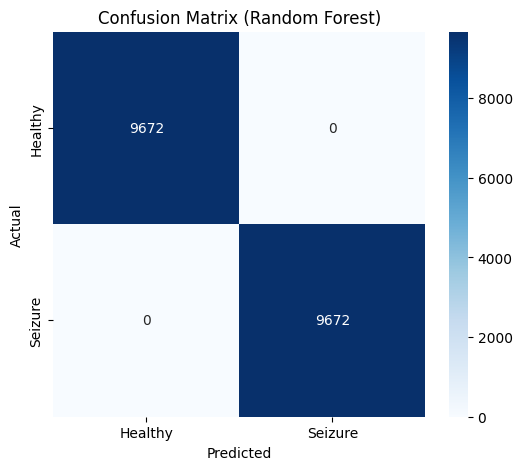

In [ ]:
# ==========================================
# BLOCK 6: AGGRESSIVE TRAINING WITH SMOTE (UPDATED)
# ==========================================
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("🧠 Training with SMOTE (Random Forest Only)...")

# 1. LOAD DATA
df_train = pd.read_csv("train_features.csv")

# 2. SEPARATE QUESTIONS (X) AND ANSWERS (y)
y_train = df_train.pop('label').values
X_train = df_train.values

# 3. BALANCE THE DATA (SMOTE)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"   -> Original Samples: {len(X_train)}")
print(f"   -> After SMOTE:      {len(X_train_res)} (Balanced!)")

# 4. SCALE THE DATA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)

# 5. TRAIN THE BRAIN
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_res)

models = {"Random Forest": rf_model}

# 6. QUICK CHECK & METRICS
train_pred = rf_model.predict(X_train_scaled)

print("\n📊 --- MODEL PERFORMANCE REPORT (TRAINING DATA) ---")
print(f"✅ Accuracy: {accuracy_score(y_train_res, train_pred)*100:.2f}%")

# DETAILED REPORT (Precision, Recall, F1-Score)
print("\n📝 Classification Report:")
print(classification_report(y_train_res, train_pred, target_names=['Healthy', 'Seizure']))

# CONFUSION MATRIX VISUALIZATION
cm = confusion_matrix(y_train_res, train_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Seizure'], yticklabels=['Healthy', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

In [ ]:
# ==========================================
# BLOCK 7: TESTING ON NEW PATIENT (chb10) - WITH METRICS
# ==========================================
import os
import mne
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("🏥 Testing on New Patient (chb10)...")

# 1. DOWNLOAD & LOAD FILE
test_file = "chb10_12.edf"
if not os.path.exists(test_file):
    os.system(f"wget -q https://physionet.org/files/chbmit/1.0.0/chb10/{test_file}")

raw = mne.io.read_raw_edf(test_file, preload=True, verbose=False)
raw.rename_channels(lambda x: x.strip('.'))
raw.filter(1.0, 70.0, verbose=False)

# 2. CHOP & EXTRACT FEATURES
data = raw.get_data()
sfreq = raw.info['sfreq']
n_wins = data.shape[1] // int(4 * sfreq)

patient_features = []
true_labels = [] # We will store the "Real Answers" here

# --- DEFINING THE GROUND TRUTH (From PhysioNet Database) ---
# Seizure in chb10_12.edf is from 6313s to 6348s
SEIZURE_START_SEC = 6313
SEIZURE_END_SEC = 6348

print(f"🧠 Scanning {n_wins} windows (approx {n_wins*4/60:.1f} minutes)...")

for i in range(n_wins):
    # Cut 4-second clip
    clip = data[:, i*1024 : (i+1)*1024]

    # Extract features
    row = []
    for ch in range(clip.shape[0]):
        row.extend(extract_advanced_features(clip[ch], sfreq))
    patient_features.append(row)

    # Create the "Real Answer" for this window
    window_start_time = i * 4
    window_end_time = (i + 1) * 4

    # If the window overlaps with the seizure time, label it '1' (Seizure)
    if (window_start_time >= SEIZURE_START_SEC) and (window_start_time <= SEIZURE_END_SEC):
        true_labels.append(1)
    else:
        true_labels.append(0)

# 3. NORMALIZE
X_test_new = scaler.transform(patient_features)

# 4. PREDICT
probs = models["Random Forest"].predict_proba(X_test_new)[:, 1]
y_pred = (probs > 0.5).astype(int) # Convert probabilities to 0 or 1

# 5. RESULTS & METRICS
print("\n📊 --- FINAL TEST RESULTS (chb10_12.edf) ---")

# Compare AI Predictions (y_pred) vs Real Answers (true_labels)
acc = accuracy_score(true_labels, y_pred)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

print("\n📝 Detailed Report:")
print(classification_report(true_labels, y_pred, target_names=['Healthy', 'Seizure']))

# Check if we caught the specific seizure
seizure_indices = np.where(y_pred == 1)[0]

#his [0] is a "Wrapper Remover." np.where creates a Package (a tuple) containing the list of results..[0] opens the package and pulls out the actual List
# Imagine your probability list is: probs = [0.1, 0.9, 0.2, 0.8]..You run the command np.where(probs > 0.5).
# Without [0] (The raw output)..The computer returns a Tuple ...(array([1, 3]), )
# It is saying: "Here is a tuple. Inside it, I have put an array. Inside that array are indices 1 and 3."
# This format is annoying to work with because the list is trapped inside the parentheses.
# With [0] (The clean output)...You tell Python: "Give me the item at index 0 of that tuple."..array([1, 3])

if len(seizure_indices) > 0:
    first_detection = seizure_indices[0]
    seconds = first_detection * 4
    print(f"🚨 ALARM: SEIZURE DETECTED at {seconds//60}m {seconds%60}s")
    print(f"   (Real Seizure started at {SEIZURE_START_SEC//60}m {SEIZURE_START_SEC%60}s)")
else:
    print("✅ Normal (No seizures detected)")

🏥 Testing on New Patient (chb10)...


/tmp/ipython-input-4222496890.py:16: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(test_file, preload=True, verbose=False)


🧠 Scanning 1800 windows (approx 120.0 minutes)...

📊 --- FINAL TEST RESULTS (chb10_12.edf) ---
✅ Test Accuracy: 89.44%

📝 Detailed Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.90      0.94      1791
     Seizure       0.02      0.33      0.03         9

    accuracy                           0.89      1800
   macro avg       0.51      0.62      0.49      1800
weighted avg       0.99      0.89      0.94      1800

🚨 ALARM: SEIZURE DETECTED at 0m 24s
   (Real Seizure started at 105m 13s)


In [ ]:
# predict_proba(X_scaled)
# Unlike a normal prediction which just says "Yes" or "No", this command asks the AI for the Percentage of Confidence.
# For every 4-second window, the AI returns two numbers:
# The chance it is Normal (Label 0).
# The chance it is a Seizure (Label 1).

# 2. The Slicer [:, 1]
# The syntax [ ... , ... ] has two slots separated by a comma: [ Rows , Columns ].
# The Colon (:): This symbol means "ALL".
# In the Row slot, it means: "Keep ALL the windows (1, 2, 3...)."
# The Number (1): This means "Index 1".
# In the Column slot, it means: "Keep ONLY Column 1 (The Seizure Column)."
# By running that code, you delete the "Normal" column and keep just the list of Seizure risks.
# Before: [[0.99, 0.01], [0.20, 0.80], [0.95, 0.05]]
# After [:, 1]: [0.01, 0.80, 0.05]